# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [29]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

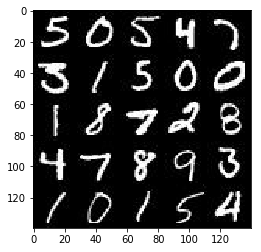

In [30]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

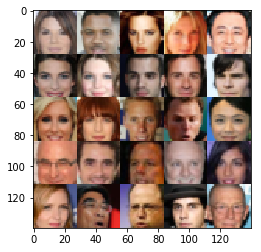

In [31]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [32]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [33]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels))
    zz = tf.placeholder(dtype=tf.float32, shape=(None, z_dim))
    learn_rate = tf.placeholder(dtype=tf.float32)
    return inputs, zz, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [34]:
def discriminator(images, reuse=False, alpha = 0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        c1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        c1 = tf.maximum(alpha*c1, c1)
        
        c2 = tf.layers.conv2d(c1, 256, 5, strides=2, padding='same')
        c2 = tf.layers.batch_normalization(c2, training=True)
        c2 = tf.maximum(alpha*c2, c2)
        
        c3 = tf.layers.conv2d(c2, 512, 5, strides=2, padding='same')
        c3 = tf.layers.batch_normalization(c3, training=True)
        c3 = tf.maximum(alpha*c3, c3)
        
        flat = tf.reshape(c3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [35]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = (not is_train)):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
    
        out = tf.tanh(logits)
        
    return out    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [36]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [37]:
def model_opt(d_loss, g_loss, learning__rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning__rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning__rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [38]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,  print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
#     saver = tf.train.Saver()
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    steps = 0
    losses = []
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, len(data_image_mode), data_image_mode)         
#         #saver.save(sess, './checkpoints/facegenerator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/1... Discriminator Loss: 0.1931... Generator Loss: 20.0290
Epoch 1/1... Discriminator Loss: 0.0174... Generator Loss: 20.0096
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.4060
Epoch 1/1... Discriminator Loss: 8.9756... Generator Loss: 0.0026
Epoch 1/1... Discriminator Loss: 0.3128... Generator Loss: 2.7786
Epoch 1/1... Discriminator Loss: 0.8574... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 2.2244
Epoch 1/1... Discriminator Loss: 2.6690... Generator Loss: 0.1342
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 1.0950


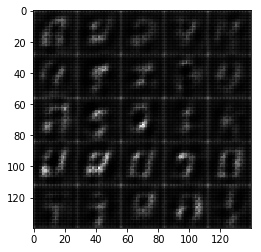

Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 1.6845
Epoch 1/1... Discriminator Loss: 1.8630... Generator Loss: 0.2424
Epoch 1/1... Discriminator Loss: 1.7291... Generator Loss: 0.2946
Epoch 1/1... Discriminator Loss: 2.1187... Generator Loss: 0.1823
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.7672
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 2.1632
Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.3648


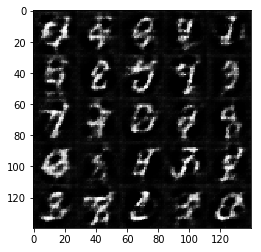

Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.4688
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 1.6487
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 2.1996
Epoch 1/1... Discriminator Loss: 2.5512... Generator Loss: 0.1141
Epoch 1/1... Discriminator Loss: 0.9593... Generator Loss: 1.1090
Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.7316
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.5444
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 2.0318... Generator Loss: 3.8936
Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.0717


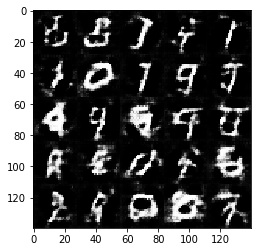

Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.4524
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 2.5167... Generator Loss: 0.1442
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.7859
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.9588
Epoch 1/1... Discriminator Loss: 2.0285... Generator Loss: 0.2208
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 2.5485
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.0160
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 0.7086


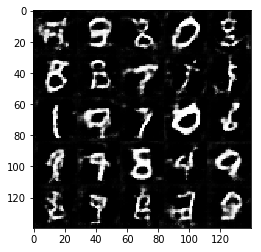

Epoch 1/1... Discriminator Loss: 0.8555... Generator Loss: 1.1995
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 2.4044... Generator Loss: 0.1455
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 1.7118
Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 0.3868
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 2.1357
Epoch 1/1... Discriminator Loss: 2.1855... Generator Loss: 0.1789


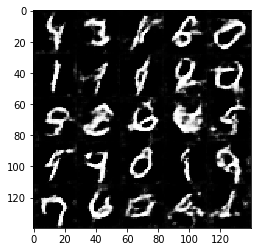

Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 1.1602
Epoch 1/1... Discriminator Loss: 1.7072... Generator Loss: 0.3017
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.4114
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 1.9743
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.8903... Generator Loss: 0.2873
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 2.2678... Generator Loss: 4.2838


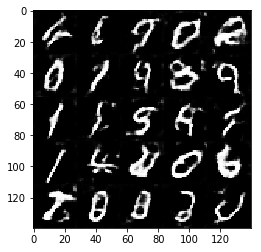

Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.5258
Epoch 1/1... Discriminator Loss: 1.5998... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.4242
Epoch 1/1... Discriminator Loss: 3.3088... Generator Loss: 0.0691
Epoch 1/1... Discriminator Loss: 1.9502... Generator Loss: 0.2326
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 1.1498
Epoch 1/1... Discriminator Loss: 3.1410... Generator Loss: 0.0919
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 2.9544
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.1507


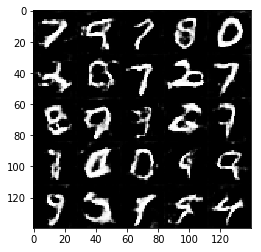

Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 0.8556... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 2.4741
Epoch 1/1... Discriminator Loss: 1.0315... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 0.9943
Epoch 1/1... Discriminator Loss: 2.0843... Generator Loss: 0.2162
Epoch 1/1... Discriminator Loss: 0.5718... Generator Loss: 1.6220
Epoch 1/1... Discriminator Loss: 2.4784... Generator Loss: 0.2047
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 2.4023
Epoch 1/1... Discriminator Loss: 1.1605... Generator Loss: 0.6511


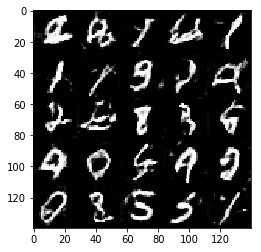

Epoch 1/1... Discriminator Loss: 0.8154... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 2.3371
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.4588
Epoch 1/1... Discriminator Loss: 3.0125... Generator Loss: 0.0937
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 2.2528... Generator Loss: 0.1904
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 1.3337
Epoch 1/1... Discriminator Loss: 1.9316... Generator Loss: 0.2813
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 1.2338
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 1.2307


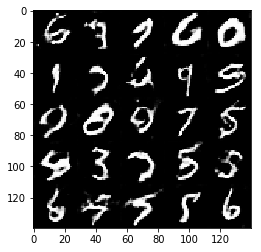

Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.7411
Epoch 1/1... Discriminator Loss: 1.6902... Generator Loss: 0.4593
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.8777


In [40]:
batch_size = 64
z_dim = 128
learning_rate = 0.005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.0582... Generator Loss: 20.3501
Epoch 1/1... Discriminator Loss: 0.0638... Generator Loss: 7.0316
Epoch 1/1... Discriminator Loss: 3.4294... Generator Loss: 2.8004
Epoch 1/1... Discriminator Loss: 0.2381... Generator Loss: 3.3722
Epoch 1/1... Discriminator Loss: 3.4091... Generator Loss: 0.0665
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 2.8160
Epoch 1/1... Discriminator Loss: 0.1870... Generator Loss: 3.8609
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.5201
Epoch 1/1... Discriminator Loss: 1.8860... Generator Loss: 0.6720


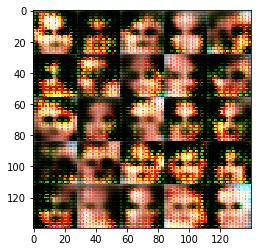

Epoch 1/1... Discriminator Loss: 2.2025... Generator Loss: 0.2037
Epoch 1/1... Discriminator Loss: 0.5245... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 0.3826... Generator Loss: 2.0202
Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 1.4621
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.2828
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 2.1863... Generator Loss: 3.5186
Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 3.4027
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 1.0675


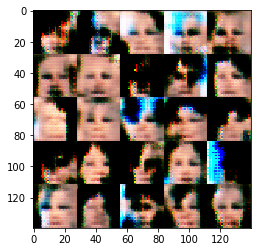

Epoch 1/1... Discriminator Loss: 0.2950... Generator Loss: 1.9316
Epoch 1/1... Discriminator Loss: 0.3457... Generator Loss: 1.7684
Epoch 1/1... Discriminator Loss: 14.5717... Generator Loss: 12.8007
Epoch 1/1... Discriminator Loss: 0.8599... Generator Loss: 1.1347
Epoch 1/1... Discriminator Loss: 1.6038... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.9243
Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.9814


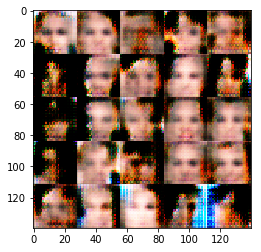

Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 0.7237... Generator Loss: 2.3190
Epoch 1/1... Discriminator Loss: 2.5515... Generator Loss: 0.1464
Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 2.4810
Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 2.4843
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 0.8123... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 0.3891... Generator Loss: 1.4474
Epoch 1/1... Discriminator Loss: 0.6204... Generator Loss: 1.9208
Epoch 1/1... Discriminator Loss: 0.6108... Generator Loss: 1.4982


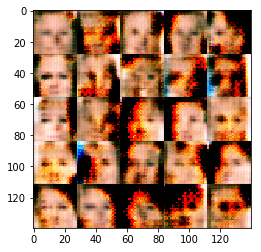

Epoch 1/1... Discriminator Loss: 0.7069... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.0669... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 2.3026
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 2.1015... Generator Loss: 3.5989
Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.3870
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 0.6562... Generator Loss: 1.1563


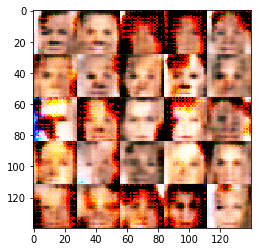

Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 1.5276
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 1.8743
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.1074
Epoch 1/1... Discriminator Loss: 0.4991... Generator Loss: 1.1172
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 1.8351
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 0.8423


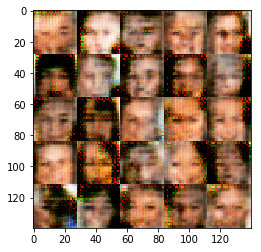

Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 0.5131... Generator Loss: 1.1302
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.4301
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.2104
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 1.6218
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 0.8866... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.7970... Generator Loss: 1.4013


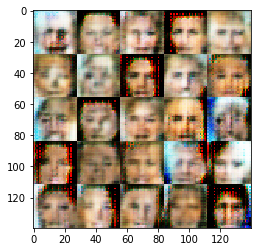

Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 1.0440
Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 0.2784... Generator Loss: 2.6628
Epoch 1/1... Discriminator Loss: 0.5403... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 1.8989... Generator Loss: 0.3231
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 0.7564


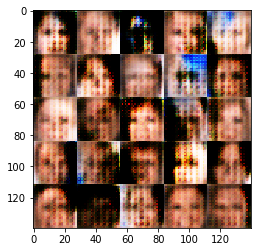

Epoch 1/1... Discriminator Loss: 0.2907... Generator Loss: 2.2130
Epoch 1/1... Discriminator Loss: 1.1977... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 0.3366... Generator Loss: 1.8725
Epoch 1/1... Discriminator Loss: 2.3626... Generator Loss: 0.2054
Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.9662
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 2.6020
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.6495


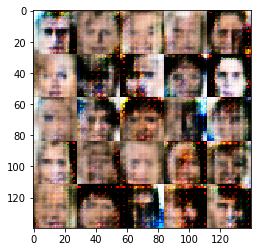

Epoch 1/1... Discriminator Loss: 2.5243... Generator Loss: 0.1404
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 0.6850... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.8267... Generator Loss: 2.1070
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 0.7767


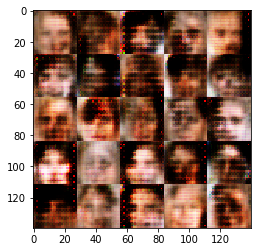

Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.5708
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 0.9684... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.1442
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 0.8407... Generator Loss: 1.2174
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 0.8938


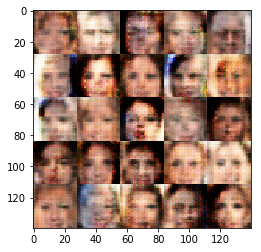

Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.0303... Generator Loss: 1.0919
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.9611
Epoch 1/1... Discriminator Loss: 0.7015... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 2.2197... Generator Loss: 0.2571
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.5550
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.0307... Generator Loss: 1.0827
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.5231


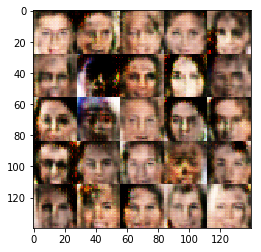

Epoch 1/1... Discriminator Loss: 1.7269... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.1964... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.0624... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 0.9143... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 1.1470


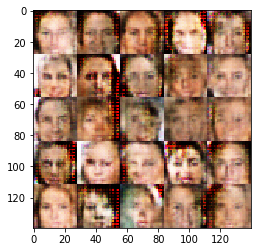

Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 0.9180
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 2.7490
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 1.7771


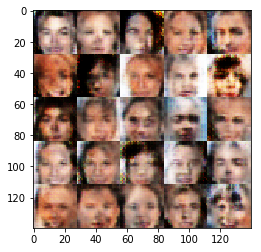

Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.4186
Epoch 1/1... Discriminator Loss: 0.9965... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.1945
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 0.9853... Generator Loss: 1.0816
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.1491... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.8243


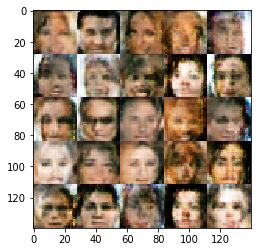

Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.0840... Generator Loss: 1.0646
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.5431
Epoch 1/1... Discriminator Loss: 1.0348... Generator Loss: 1.1586
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.2971
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.3983
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.7907


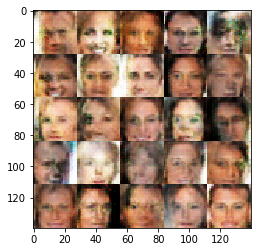

Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.4990
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.0323
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.7357
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 1.2011


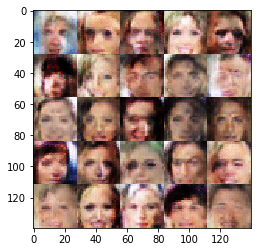

Epoch 1/1... Discriminator Loss: 1.6735... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.7724... Generator Loss: 0.3637
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 1.3344
Epoch 1/1... Discriminator Loss: 0.6660... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 1.2844
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7084


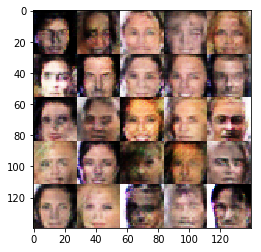

Epoch 1/1... Discriminator Loss: 0.6370... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 0.8951... Generator Loss: 1.2553
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 1.7371
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 0.3028... Generator Loss: 1.7703
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 0.9571


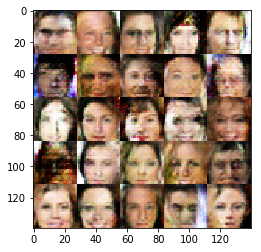

Epoch 1/1... Discriminator Loss: 1.1060... Generator Loss: 1.4372
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.2045
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.4348
Epoch 1/1... Discriminator Loss: 0.6417... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 0.8091... Generator Loss: 0.8192
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 1.1177
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.7684


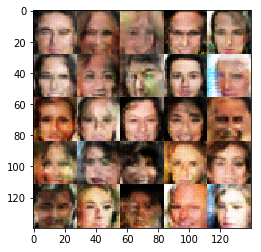

Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.4407
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.2655
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.6118
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.6525
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 0.9448


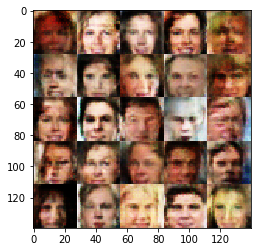

Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.5059
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.4757
Epoch 1/1... Discriminator Loss: 2.8401... Generator Loss: 2.2765
Epoch 1/1... Discriminator Loss: 1.7745... Generator Loss: 0.3543
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.2210
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.8054


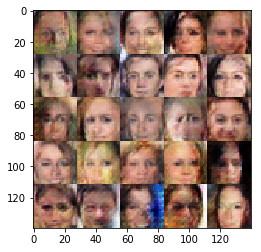

Epoch 1/1... Discriminator Loss: 0.8708... Generator Loss: 1.0282
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 0.7872
Epoch 1/1... Discriminator Loss: 0.7166... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.3921
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.4912
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.0812... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.0430... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 0.6373... Generator Loss: 1.0511
Epoch 1/1... Discriminator Loss: 1.0208... Generator Loss: 0.5824


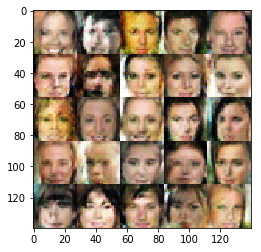

Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.0194
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.2622
Epoch 1/1... Discriminator Loss: 0.7936... Generator Loss: 1.3623
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.9110
Epoch 1/1... Discriminator Loss: 0.4190... Generator Loss: 1.3853
Epoch 1/1... Discriminator Loss: 0.5881... Generator Loss: 1.5703
Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.0009


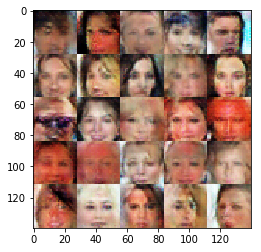

Epoch 1/1... Discriminator Loss: 1.9514... Generator Loss: 0.2569
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.0805
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 1.3014
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.2425
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 0.9705


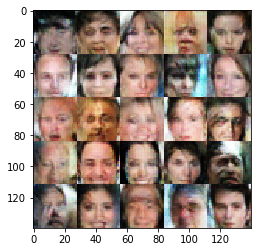

Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.5131
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 2.3360
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 0.9054
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 1.3070... Generator Loss: 0.7130


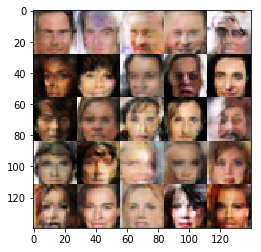

Epoch 1/1... Discriminator Loss: 2.3798... Generator Loss: 0.1743
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 0.5130... Generator Loss: 1.6010
Epoch 1/1... Discriminator Loss: 0.7818... Generator Loss: 0.9377


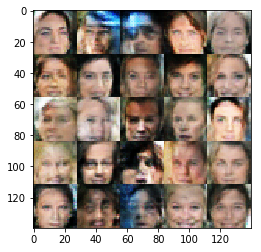

Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 1.3107
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.6841
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.4461
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 0.6322


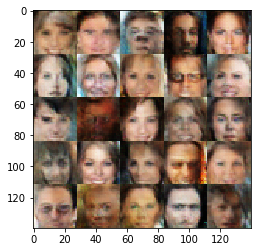

Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.5941
Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.2511
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.9699... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.4255
Epoch 1/1... Discriminator Loss: 2.0100... Generator Loss: 3.2214


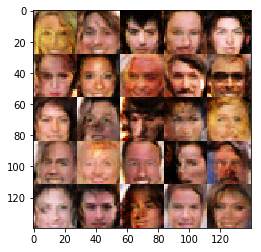

Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 0.8846... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.3061
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.1072... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 0.9257


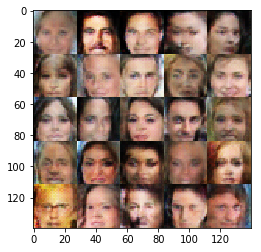

Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.0272
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.3829
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.9543


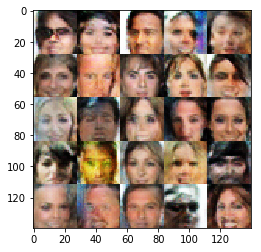

Epoch 1/1... Discriminator Loss: 2.3796... Generator Loss: 0.1928
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 2.0539
Epoch 1/1... Discriminator Loss: 2.0042... Generator Loss: 0.2345
Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 1.5527


In [42]:
batch_size = 64
z_dim = 128
learning_rate = 0.005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.